# 21M.387 Fundamentals of Music Processing
## Fourier Transform, part 2

In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)

## Reading

Chapter 2.1.4 (pp 53 – 57), 2.5 (93 – 105)

<img src="images/book_cover.png" width=200>

## The DFT
$$X(k) = \sum_{n=0}^{N-1}x(n)e^{-j 2 \pi kn / N } \text{, for } k \in [0:N-1]$$

We defined a sinusoid as:  
$$x(n) = A \cos(2 \pi {k \over N} n + \phi)$$
where $f$, the frequency of the sinusoid in Hertz is: 
$$f = k {F_s \over N}$$

Back to the first synthetic example.  
We create funky-shaped $x(n)$, by adding the following sinusoids:
- $\{A=1.0, k=1, \phi=0 \}$
- $\{A=0.6, k=3, \phi=2.1 \}$
- $\{A=0.4, k=8, \phi=0.6 \}$

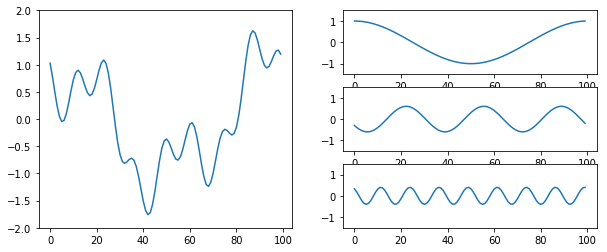

In [3]:
# back to our first example:

# helper functions:
def make_cosine(a, k, ph, N) :
    n = np.arange(N)
    return a * np.cos( 2 * np.pi * k / N * n + ph)

N = 100
c1 = make_cosine(1.0, 1, 0, N)
c2 = make_cosine(0.6, 3, 2.1, N)
c3 = make_cosine(0.4, 8, 0.6, N)
x = c1 + c2 + c3

plt.figure()
plt.subplot(1,2,1)
plt.plot(x)
plt.ylim(-2, 2)

for i, c in enumerate((c1, c2, c3)):
  plt.subplot(3, 2, 2*i+2)
  plt.plot(c)
  plt.ylim(-1.5, 1.5)


## DFT in code

To calculate the DFT, think of it as a series of $N$ dot products, each one calculating the value for a different $k$.

The entire expression can be expressed as a single Matrix Multiply.

In [4]:
def make_dft_fb(N):
    # create "probes" matrix:
    P = np.zeros((N,N), dtype=np.complex)
    j2pn = -2j * np.pi / N * np.arange(N)
    for k in range(N):
        P[k,:] = np.exp(j2pn * k)

    return P

# another way of creating the same DFT matrix:
def make_dft_fb(N):
    n = np.arange(N)
    kn = np.outer(n, n)
    return np.exp( -2j * np.pi / N * kn)
    
def dft(x):
    N = len(x)
    fb = make_dft_fb(N)
    
    return np.dot(fb, x)

The DFT of $x(n)$ is plotted below, using our own `dft` function and `np.fft.fft`

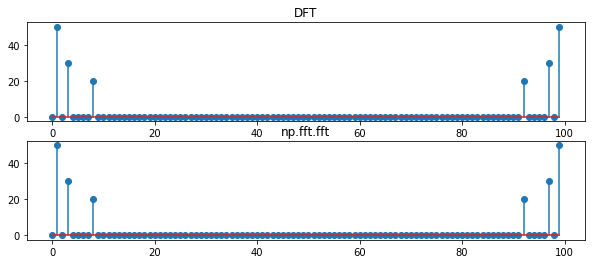

In [5]:
ft1 = dft(x)
ft2 = np.fft.fft(x)

plt.subplot(2,1,1)
plt.stem(np.abs(ft1))
plt.title('DFT')

plt.subplot(2,1,2)
plt.stem(np.abs(ft2));
plt.title('np.fft.fft');



It works!

Let's look at the DFT Matrix graphically.

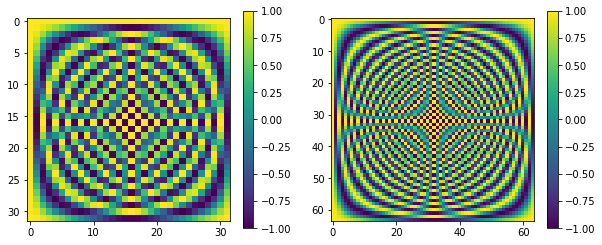

In [6]:
dft_fb32 = make_dft_fb(32)
dft_fb64 = make_dft_fb(64)

plt.subplot(1,2,1)
plt.imshow(dft_fb32.real, interpolation='nearest')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(dft_fb64.real, interpolation='nearest')
plt.colorbar();


Pretty! And Symmetric.

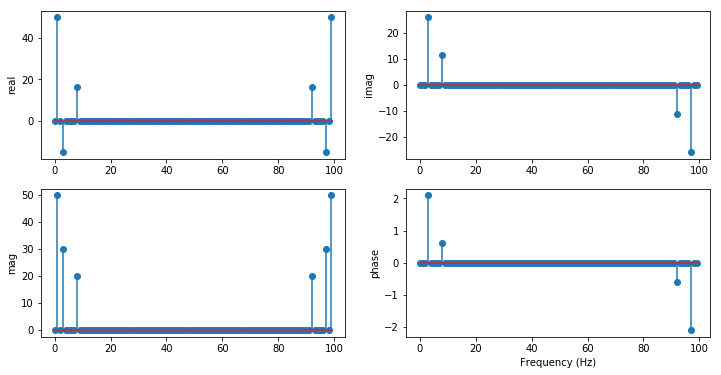

In [7]:
ft = np.fft.fft(x)

ft_mag = np.abs(ft)
ft_ph  = np.angle(ft)

ft_ph[ ft_mag < 0.0001] = 0

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.stem(ft.real)
plt.ylabel('real')
plt.subplot(2,2,2)
plt.stem(ft.imag)
plt.ylabel('imag')
plt.subplot(2,2,3)
plt.stem(ft_mag)
plt.ylabel('mag')
plt.subplot(2,2,4)
plt.stem(ft_ph)
plt.ylabel('phase')

plt.xlabel('Frequency (Hz)');

Note that the DFT is symmetric. If $x(n)$ is a _real_ signal (which is always the case for us), the 2nd half of the DFT is redundant, and is therefore often dropped.

The useful information for the DFT therefore resides in the range $k \in [0, N/2 + 1]$

## The Fast Fourier Transform

Computing the DFT for $x(n)$ of length $N$ using the above equations is an $O(N^2)$ operation.  
Because of certain symmetry properties in the calulcations, an optimzed version of the DFT can be achieved in $O(N \log N)$ if $N$ is a power of 2.

This difference in computation time is significant. For example:
- DFT with $N = 1024$ needs ~1M mult-and-add operations
- FFT with $N = 1024$ needs ~10k mult-and-add operations. That's 100 times faster!

To handle non-power-of-2 $N$, you can:
- zero-pad $x(n)$ to the next power of two.
- use `np.fft.fft` anyway. There are fast DFT algorithms for non-power-of-two as well.

Also note that since $x(n)$ is _real_ you can use `np.fft.rfft` which computes only $N/2+1$ points (and is twice as fast).

In [8]:
# here are some timed examples:
x = np.random.random(1024)

print '\nRegular DFT'
%timeit dft(x)


Regular DFT
10 loops, best of 3: 126 ms per loop


In [9]:
print '\nRegular FFT'
%timeit np.fft.fft(x)


Regular FFT
The slowest run took 4.86 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.8 µs per loop


In [10]:
print '\nReal FFT'
%timeit np.fft.rfft(x)


Real FFT
The slowest run took 8.22 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 25 µs per loop


In [11]:
print '\nNon power-of-two FFT'
x = np.random.random(1023)
%timeit np.fft.rfft(x)


Non power-of-two FFT
The slowest run took 5.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 50 µs per loop


## Spectral Leakage

What about this:

In [12]:
def magft(x):
    return np.abs(np.fft.rfft(x))

@interact(k=(6.0,8.0))
def cos_and_dft(k = 7.5):
    N = 128
    x = make_cosine(1.0, k, 0, N)
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x)
    plt.ylim(-1.5, 1.5)
    plt.title('$x(n)$')
    plt.subplot(1,2,2)
    plt.stem(magft(x))
    plt.ylim(0,65)
    plt.title('$|X(k)|$')
    plt.show()


interactive(children=(FloatSlider(value=7.5, description=u'k', max=8.0, min=6.0), Output()), _dom_classes=('widget-interact',))

The "problem" is that the frequency $k = 7.5$ is not an integer and is thus not "perfectly capturable" by a DFT, since all values of $k$ are integers.

You can explain this in a few ways

The DFT behaves as if signal $x(n)$ is actually _periodically extended_ in both directions to form in an infinite signal. Doing this on a non-integer $k$ results in a "glitch":

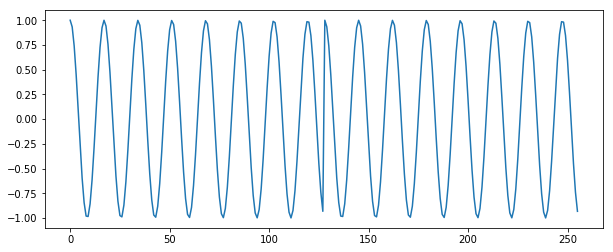

In [13]:
# periodically extend x:
N = 128
x = make_cosine(1.0, 7.5, 0, N)
y = np.tile(x, 2)

plt.figure()
plt.plot(y);

You can think of this glitch as a high-frequency spike that introduces lots of other frequencies or "sidebands"

Or: the DFT must "hack together" a bunch of integer frequency sinusoids with different weights and phases to create the non-integer frequency.

In [14]:
# pull out Amp, K, and phase from FFT:
x_ft = np.fft.rfft(x)
x_amp = np.abs(x_ft) * 2 / N
x_phase = np.angle(x_ft)
cos_params = zip(x_amp, np.arange(len(x_amp)), x_phase)

# but now, sort them in order of amplitude (the "most important" ones first)
cos_params.sort(key = lambda(x) : x[0], reverse=True)

@interact(num_sines=(0, len(cos_params) - 1))
def reconstruct(num_sines=0):
    x = np.zeros(N)
    y = np.zeros(N)
    params_txt = ''
    for p in cos_params[:num_sines]:
        y = make_cosine(p[0], p[1], p[2], N)
        params_txt = 'A=%.2f k=%d, phi=%.2f' % p
        x += y
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(y, 'r')
    plt.ylim(-1.5, 1.5);
    plt.text(10, 1, params_txt, fontsize=20)
    plt.subplot(2,1,2)
    plt.plot(x)
    plt.ylim(-1.5, 1.5)
    plt.title("sum of top %d sinusoids" % num_sines)
    plt.show();


interactive(children=(IntSlider(value=0, description=u'num_sines', max=64), Output()), _dom_classes=('widget-interact',))

## Zero-padding

Zero padding the signal $x(n)$ will cause finer frequency interpolation.

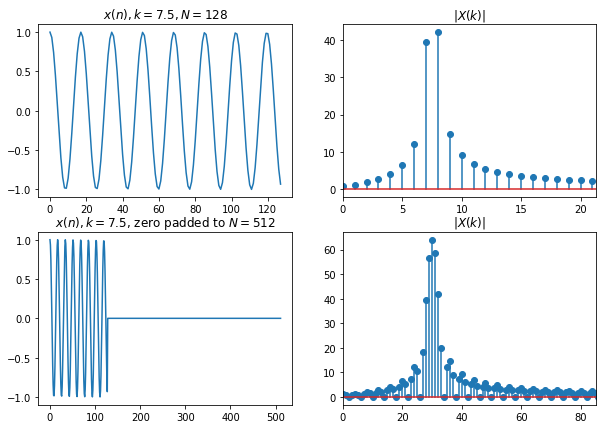

In [15]:
zp_len = 512 - len(x)
y = np.concatenate((x, np.zeros(zp_len)))

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.plot(x)
plt.title('$x(n), k=7.5, N=128$')
plt.subplot(2,2,2)
plt.stem(magft(x))
plt.xlim(0, len(x)/6.)
plt.title('$|X(k)|$')
plt.subplot(2,2,3)
plt.plot(y)
plt.title('$x(n), k=7.5$, zero padded to $N=512$')
plt.subplot(2,2,4)
plt.stem(magft(y))
plt.xlim(0, len(y)/6.)
plt.title('$|X(k)|$')
plt.show()

Another example:
$$ x(n) = \cos(2 \pi {k_1 \over N} n) + \cos(2 \pi {k_2 \over N} n) $$
with:
- $ k_1 = 49.2$
- $ k_2 = 53.7$

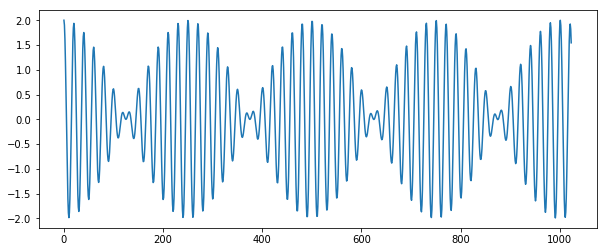

In [16]:
c1 = make_cosine(1, 49.1, 0, 1024)
c2 = make_cosine(1, 53.2, 0, 1024)
x = c1 + c2
plt.plot(x)
plt.show()

See how the DFT resolution changes as we modify the _amount_ of signal and the _amount_ of zero-padding.

In [17]:
@interact(zpf=(1,8), ni=(0,3))
def zp_test(zpf=1, ni=0):
    sig_len = (128,256,512,1024)[ni]
    N = sig_len * zpf
    xw = np.concatenate((x[:sig_len], np.zeros(N-sig_len)))
    mft = np.abs(np.fft.rfft(xw))
    peaks = find_peaks(mft, .5)
    
    plt.figure(figsize=(10, 7))
    plt.subplot(2,1,1)
    plt.plot(xw)
    txt = '$N=%d$    $L_{sig} = %d$    $L_{zp} = %d$' % (N, sig_len, N - sig_len)
    plt.title(txt)
    plt.subplot(2,1,2)
    plt.title('$|X(k)|$')
    plt.plot(mft[0:int(N/8)])
    plt.show()

interactive(children=(IntSlider(value=1, description=u'zpf', max=8, min=1), IntSlider(value=0, description=u'ni', max=3), Output()), _dom_classes=('widget-interact',))

### Non-Stationary Signals

The DFT says nothing about _when_ frequencies occur. For long stretches of audio that changes over time, we need a better tool.

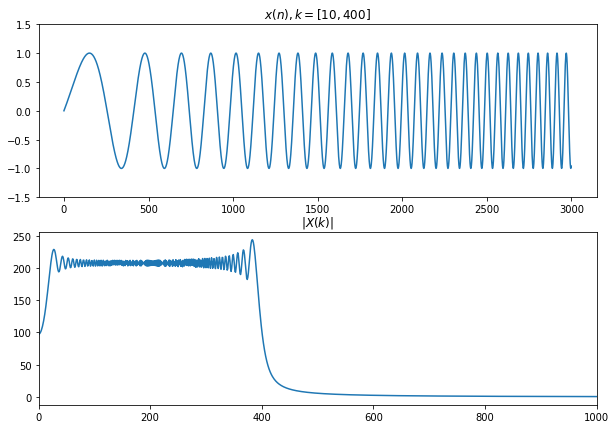

In [18]:
def make_chirp(k_start, k_end, N) :
    n = np.arange(N)
    dk = (k_end - k_start) / float(N)
    return np.sin(2*np.pi * (k_start + dk/2 * n) * n / N)

N = 8192
x = make_chirp(10, 400, N)
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(x[0:3000])
plt.ylim(-1.5, 1.5)
plt.title('$x(n), k=[10,400]$ ')
plt.subplot(2,1,2)
plt.plot(magft(x))
plt.xlim(0,1000);
plt.title('$|X(k)|$')

ipd.Audio(x, rate = N)


### Sliding Window

To pick a window of a signal, we choose a smaller portion of the signal and truncate.

It is often useful to pick a window shaping function, such as the _Hann_ window.

In [19]:
def window(x, w_start, win) :
    x_win = win * x[w_start:w_start+len(win)]
    win_zp = np.zeros(len(x))
    win_zp[w_start:w_start+len(win)] = win
    x_win_zp = np.zeros(len(x))
    x_win_zp[w_start:w_start+len(win)] = x_win

    return x_win, win_zp, x_win_zp

win_len = 1024
win_pos = np.array((0,1,2,3)) * win_len

@interact(p=(0,3), w=(0,2))
def sliding_window(p=0, w=0):
    # choose window:
    win = (np.ones(win_len), scipy.signal.triang(win_len), np.hanning(win_len))[w]
    
    x_win, win_zp, x_win_zp = window(x, win_pos[p], win)
    
    plt.figure(figsize=(10,8))
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.plot(win_zp, 'r', linewidth=2)
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 5000)

    plt.subplot(3,1,2)
    plt.plot(x_win_zp)
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 5000)

    plt.subplot(3,2,5)
    plt.plot(x_win)

    plt.subplot(3,2,6)
    plt.plot(magft(x_win))
    plt.xlim(0, 60)
    plt.show()


interactive(children=(IntSlider(value=0, description=u'p', max=3), IntSlider(value=0, description=u'w', max=2), Output()), _dom_classes=('widget-interact',))

Let's try the same thing, but with a real piece of audio

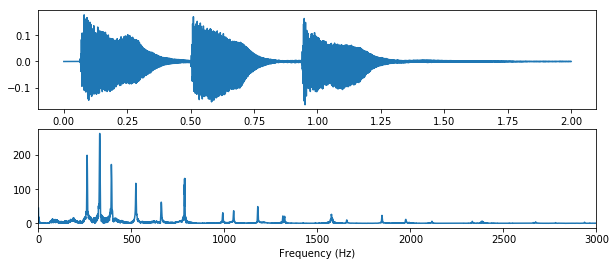

In [20]:
plot_fft_and_listen('audio/piano_arpeg.wav')

In [21]:
x = load_wav('audio/piano_arpeg.wav') * 5
fs = 22050.
w_len = 2048
win_pos = np.arange(15) * 2000

@interact(p=(0,len(win_pos)-1))
def sliding_window(p=0):
    # choose window:
    win = np.hanning(w_len)
    
    x_win, win_zp, x_win_zp = window(x, win_pos[p], win)

    ft_mag = magft(x_win)
    
    plt.figure(figsize=(10,8))
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.plot(win_zp, 'r', linewidth=2)
    plt.ylim(-1.5, 1.5)
    plt.subplot(3,1,2)
    plt.plot(x_win_zp)
    plt.ylim(-1.5, 1.5)
    plt.subplot(3,1,3)
    plt.plot(ft_mag)
    plt.xlim(0, 120)
    plt.ylim(0, 300)
    txt = '$k_{max} = %d$' % np.argmax(ft_mag)
    plt.text(100, 250, txt, size=18)
    plt.show()


interactive(children=(IntSlider(value=0, description=u'p', max=14), Output()), _dom_classes=('widget-interact',))

In [22]:
k = 24

f = k * fs / w_len
print "freq = %.2f Hz" % f

p = 64
print "pitch = %.2f" % fmp.freq_to_pitch(f)

freq = 258.40 Hz
pitch = 59.79


### The Short Term Fourier Transform

The STFT is the manifestation of the above process. We slide a window across the audio signal and collect the DFT at each step.

The parameters of interest in the STFT are:
- the window length, $N$
- the hop size, $H$
- the window shape (most often, _Hann_ is chosen)

The magnitude of the STFT is called the _spectrogram_.

In [23]:
x = load_wav('audio/piano_arpeg.wav')
fs = 22050
win_len = 2048
hop_size = win_len / 4

spec = fmp.stft_mag(x, win_len, hop_size)

print 'Spectrogram matrix size:', spec.shape

Spectrogram matrix size: (1025, 85)


'spec' is a 2D matrix.

- rows are the FFT bins, indexed by $k \in [0, N/2+1]$
- columns are the "hops", representing points in time, indexed by $m \in [0, M-1]$, where $M$ is the total number of hops

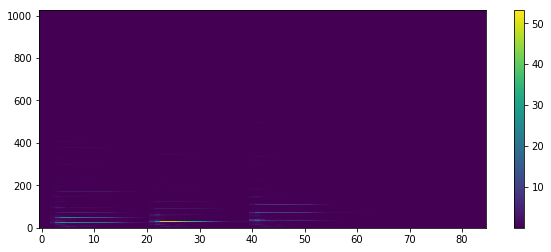

In [24]:
plt.figure()
plt.imshow(spec, origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();

Hmmm. this looks mostly dark. It is very common to view a spectrogram by applying a log scale to the amplitudes:

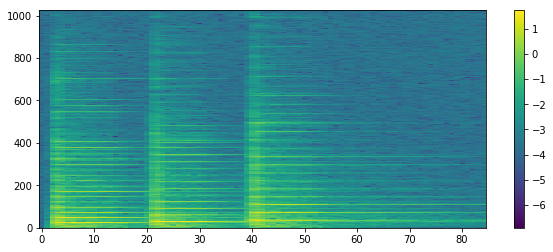

In [25]:
plt.figure()
plt.imshow(np.log10(spec), origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();

That's very bright!. Also, we could run into trouble because: $\log_{10}(0) = -\infty$.

Typically, we use a comperssion factor to determine how much we want to boost low values:

$\Gamma_\gamma(v) = \log(1+ \gamma \cdot v)$

- $v$ is the value to compress
- $\gamma$ is the compression factor


In [26]:
@interact(g_idx=(0,5))
def spec_gamma(g_idx=0):
    gamma = (.1,1,10,100,1000,10000)[g_idx]
    plt.figure()
    x = np.linspace(0.0001, 100, 500)
    plt.plot(x, np.log10(1 + x * gamma))
    plt.xlabel('$v$', fontsize=15)
    plt.ylabel('$\Gamma(v)$', fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'g_idx', max=5), Output()), _dom_classes=('widget-interact',))

In [27]:
@interact(g_idx=(0,4))
def spec_gamma(g_idx=0):
    gamma = (1,10,100,1000,10000)[g_idx]
    plt.figure()
    plt.imshow(np.log10(1 + spec * gamma), origin='lower', interpolation='nearest', aspect='auto')
    plt.colorbar();
    plt.text(65, 900, '$\gamma = %d$' % gamma, size=15, bbox=dict(fc='white'))
    plt.show()

interactive(children=(IntSlider(value=0, description=u'g_idx', max=4), Output()), _dom_classes=('widget-interact',))

As you can see, enhancing small values also enhances noise in the signal.

### Sidebar: Plotting vs Matrix Axes

Note also that we typically plot with:
- `origin = 'lower'`
- `interpolation = 'nearest'`

But remember that we think of a matrix's origin is top-left.

### STFT coordinates

Frequency of each bin (each row):
- $ f(k) = k F_s / N $
- example: for $f(k=20) = 20 \cdot {22050 \over 1024} = 430.66$Hz
- frequency resolution is: ${22050 \over 1024} = 21.53$

Time resultion of columns (or "feature rate"):
- $ F_f = F_s / H $
- example: $F_f = {22050 \over 256} = 86.13$Hz or $T_f = 1/F_f = 11.6$ms


### Time-Frequency Tradeoff

Consdier the following signal. It has two sinusoidal frequencies and two "hits".

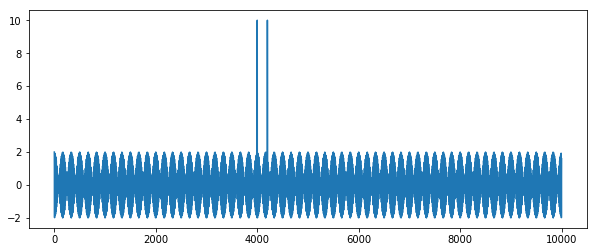

In [28]:
N = 10000
x = make_cosine(1, 1000, 0, 10000) + make_cosine(1, 1060, 0, 10000)
x[4000] = 10
x[4200] = 10

plt.figure()
plt.plot(x);

In [29]:
win_len = (128,256,512,1024)
zp_factor = (8,4,2,1)
@interact(w=(0,3))
def spec_gamma(w=0):
    wl = win_len[w]
    zp = zp_factor[w]
    spec = fmp.stft_mag(x, wl, 100, zp_factor=zp)[:200,:]
    plt.figure()
    plt.imshow(np.log10(1 + spec * 100), origin='lower', interpolation='nearest', aspect='auto', cmap='gray')
    plt.colorbar()
    plt.title('$L=%d$' % wl)
    plt.show()


interactive(children=(IntSlider(value=0, description=u'w', max=3), Output()), _dom_classes=('widget-interact',))

## Look and Listen

Let's look at a spectrogram of a song and follow along.

In [30]:
import os
os.system('open audio/beatles_let_it_be.wav -a "Sonic Visualiser"')


256